In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx 

# Load crime and arrest dataset
raw_crime_df = pd.read_csv('Crimes.csv')
# arrest_df = pd.read_csv('Arrests.csv')


In [3]:

# check missing values 
missing_values = raw_crime_df.isnull().sum()

# calculate the percentage of missing values for each column
missing_percentage = (missing_values / len(raw_crime_df)) * 100

print(missing_percentage)


ID                            0.000000
Case Number                   0.000000
Date                          0.000000
Block                         0.000000
IUCR                          0.000000
Primary Type                  0.000000
Description                   0.000000
Location Description          0.428809
Arrest                        0.000000
Domestic                      0.000000
Beat                          0.000000
District                      0.000040
Ward                          0.002283
Community Area                0.000080
FBI Code                      0.000000
X Coordinate                  1.516109
Y Coordinate                  1.516109
Year                          0.000000
Updated On                    0.000000
Latitude                      1.516109
Longitude                     1.516109
Location                      1.516109
Historical Wards 2003-2015    1.838827
Zip Codes                     1.516109
Community Areas               1.794532
Census Tracts            

In [5]:
# convert 'Date' to datetime
raw_crime_df['Date'] = pd.to_datetime(raw_crime_df['Date'])


# filter crime data (2014 - 2022)
start_date = '2014-01-01'
end_date = '2022-12-31'
crime_df = raw_crime_df[(raw_crime_df['Date'] >= start_date) & (raw_crime_df['Date']<= end_date)]

# clean missing values from crime data
crime_df = crime_df.dropna()

# idenfity duplicates to ensure unique primary keys
duplicates = crime_df[crime_df.duplicated(subset=['IUCR', 'Beat', 'Date'], keep=False)]

# display the duplicates
print(duplicates)


               ID Case Number                Date                   Block  \
227527      27274    JF528120 2022-12-30 22:20:00   086XX S CONSTANCE AVE   
227528      27275    JF528120 2022-12-30 22:20:00   086XX S CONSTANCE AVE   
228097   12936524    JF527058 2022-12-30 01:00:00        007XX W COUCH PL   
228102   12961557    JG126554 2022-12-30 01:00:00        007XX W COUCH PL   
228247   12936603    JF527172 2022-12-29 21:00:00     017XX S ASHLAND AVE   
...           ...         ...                 ...                     ...   
2496681   9949751    HY125133 2014-01-01 00:01:00  079XX S CHRISTIANA AVE   
2496691   9949763    HY134469 2014-01-01 00:01:00  079XX S CHRISTIANA AVE   
2496822  10301876    HY469710 2014-01-01 00:00:00      057XX S SAWYER AVE   
2496848   9728020    HX375274 2014-01-01 00:00:00         037XX W 55TH ST   
2496850   9728010    HX375272 2014-01-01 00:00:00         037XX W 55TH ST   

         IUCR                Primary Type                    Description  \

In [50]:

# clean missing values from arrest data
arrest_df = arrest_df.dropna()

#convert date to datetime
arrest_df['ARREST DATE'] = pd.to_datetime(arrest_df['ARREST DATE'])
arrest_df['ARREST DATE'] = arrest_df['ARREST DATE'].dt.strftime('%Y-%m-%d %H:%M:%S')

# extract columns for ArrestDetails_Dim
arrestDetails_dim = arrest_df[['CASE NUMBER', 'ARREST DATE', 'RACE', 'CHARGE 1 STATUTE', 'CHARGE 1 DESCRIPTION', 'CHARGE 1 TYPE', 'CHARGE 1 CLASS', 'CHARGE 2 STATUTE', 'CHARGE 2 DESCRIPTION', 'CHARGE 2 TYPE', 'CHARGE 2 CLASS', 'CHARGE 3 STATUTE', 'CHARGE 3 DESCRIPTION', 'CHARGE 3 TYPE', 'CHARGE 3 CLASS', 'CHARGE 4 STATUTE', 'CHARGE 4 DESCRIPTION', 'CHARGE 4 TYPE', 'CHARGE 4 CLASS', 'CHARGES STATUTE', 'CHARGES DESCRIPTION', 'CHARGES TYPE', 'CHARGES CLASS']].drop_duplicates(subset=['CASE NUMBER'])

# extract columns for CrimeType_Dim
crimeType_dim = crime_df[['IUCR', 'Primary Type', 'Description', 'FBI Code']].drop_duplicates(subset=['IUCR'])

# extract columns for LocationDetails_Dim
locationDetails_dim = crime_df[['Beat', 'District', 'Ward', 'Community Area', 'Location', 'Location Description']].drop_duplicates(subset=['Beat'])

display(crimeType_dim.head())
display(locationDetails_dim.head())

# Create time dimension
time_dim = crime_df[['Date']].drop_duplicates(subset=['Date'])
time_dim['Year'] = time_dim['Date'].dt.year
time_dim['Month'] = time_dim['Date'].dt.month
time_dim['Day'] = time_dim['Date'].dt.day
time_dim['Hour'] = time_dim['Date'].dt.hour
time_dim['Minute'] = time_dim['Date'].dt.minute
time_dim['Second'] = time_dim['Date'].dt.second
time_dim = time_dim.dropna(subset=['Date'])
display(time_dim.head())

# Extract columns for Incident_Fact table
incident_fact = crime_df[['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Arrest', 'Domestic', 'Beat']]
display(incident_fact.head())

,Date,Year,Month,Day,Hour,Minute,Second
227450,2022-12-31 00:00:00,2022,12,31,0,0,0
227482,2022-12-30 23:59:00,2022,12,30,23,59,0
227483,2022-12-30 23:58:00,2022,12,30,23,58,0
227484,2022-12-30 23:52:00,2022,12,30,23,52,0
227485,2022-12-30 23:45:00,2022,12,30,23,45,0


,ID,Case Number,Date,Block,IUCR,Arrest,Domestic,Beat
227450,12942593,JG104089,2022-12-31,0000X S KEDZIE AVE,1345,False,False,1124
227451,12941099,JG103276,2022-12-31,055XX S KILBOURN AVE,1320,False,False,813
227452,12944135,JG106573,2022-12-31,028XX N MAPLEWOOD AVE,2826,False,False,1411
227453,12948035,JG111113,2022-12-31,056XX N CLARK ST,0560,False,False,2012
227454,12940881,JG102918,2022-12-31,045XX W 63RD ST,1310,False,False,813


In [42]:
#convert date to datetime
arrest_df['ARREST DATE'] = pd.to_datetime(arrest_df['ARREST DATE'])
arrest_df['ARREST DATE'] = arrest_df['ARREST DATE'].dt.strftime('%Y-%m-%d %H:%M:%S')

# extract columns for ArrestDetails_Dim
arrestDetails_dim = arrest_df[['CASE NUMBER', 'ARREST DATE', 'RACE', 'CHARGE 1 STATUTE', 'CHARGE 1 DESCRIPTION', 'CHARGE 1 TYPE', 'CHARGE 1 CLASS', 'CHARGE 2 STATUTE', 'CHARGE 2 DESCRIPTION', 'CHARGE 2 TYPE', 'CHARGE 2 CLASS', 'CHARGE 3 STATUTE', 'CHARGE 3 DESCRIPTION', 'CHARGE 3 TYPE', 'CHARGE 3 CLASS', 'CHARGE 4 STATUTE', 'CHARGE 4 DESCRIPTION', 'CHARGE 4 TYPE', 'CHARGE 4 CLASS', 'CHARGES STATUTE', 'CHARGES DESCRIPTION', 'CHARGES TYPE', 'CHARGES CLASS']].drop_duplicates(subset=['CASE NUMBER'])


In [35]:
# create star schema
star_schema = pd.merge(incident_fact, crimeType_dim, how='inner', on='IUCR')
star_schema = pd.merge(star_schema, locationDetails_dim, how='inner', on=['Beat'])
star_schema = pd.merge(star_schema, arrestDetails_dim, how='inner', left_on='Case Number', right_on='CASE NUMBER')
star_schema = pd.merge(star_schema, time_dim, how='inner', on='Date')

# display the first few rows of the star schema
display(star_schema.head())

# save dimension tables as CSV files
crimeType_dim.to_csv('crimeType_dim.csv', index=False)
locationDetails_dim.to_csv('locationDetails_dim.csv', index=False)
arrestDetails_dim.to_csv('arrestDetails_dim.csv', index=False)
time_dim.to_csv('time_dim.csv', index=False)

# save fact table as CSV file
incident_fact.to_csv('incident_fact.csv', index=False)

# create a direct graph
G = nx.DiGraph()

# add nodes and edges to the graph
G.add_node('incident_fact', label='incident_fact')
G.add_node('crimeType_dim', label='crimeType_dim')
G.add_node('locationDetails_dim', label='locationDetails_dim')
G.add_node('arrestDetails_dim', label='arrestDetails_dim')
G.add_node('time_dim', label='time_dim')

# add edges to represent relationships between tables
G.add_edge('incident_fact', 'crimeType_dim')
G.add_edge('incident_fact', 'locationDetails_dim')
G.add_edge('incident_fact', 'arrestDetails_dim')
G.add_edge('incident_fact', 'time_dim')



,ID,Case Number,Date,Block,IUCR,Arrest,Domestic,Beat,Primary Type,Description,...,CHARGES STATUTE,CHARGES DESCRIPTION,CHARGES TYPE,CHARGES CLASS,Year,Month,Day,Hour,Minute,Second
0,11569288,JC119566,2019-01-16 18:27:00,029XX W JACKSON BLVD,0560,True,False,1124,ASSAULT,SIMPLE,...,720 ILCS 570.0/402-C | 625 ILCS 5.0/11-501-A-2...,PCS - POSSESSION - POSS AMT CON SUB EXCEPT (A)...,F | M | M | M,4 | A | A | C,2019,1,16,18,27,0
1,10931569,JA247224,2017-05-02 06:03:00,001XX S SACRAMENTO BLVD,0560,True,True,1124,ASSAULT,SIMPLE,...,720 ILCS 5.0/31-1-A | 720 ILCS 5.0/31-1-A | 72...,RESISTING/OBSTRUCT/PC OFF/CORR EMP/FRFTR | RES...,M | M | M | M,A | A | A | C,2017,5,2,6,3,0
2,10526063,HZ268745,2016-05-17 20:00:00,002XX S SACRAMENTO BLVD,0560,True,False,1124,ASSAULT,SIMPLE,...,720 ILCS 5.0/24-1.7-A | 720 ILCS 5.0/24-1.1-A ...,ARMED HABITUAL CRIMINAL | UUW - WEAPON - FELON...,F | F | M | M,X | 3 | A | A,2016,5,17,20,0,0
3,11920835,JC544751,2019-12-12 07:50:00,002XX S FRANCISCO AVE,1150,True,False,1124,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,...,720 ILCS 5.0/16-30-A-3 | 720 ILCS 5.0/16-30-A-...,ID THFT/OBTAIN INFO/COMMIT FEL | IDENTITY THEF...,F | F | F | F,3 | 4 | 4 | 4,2019,12,12,7,50,0
4,10858318,JA163623,2017-02-22 17:24:00,029XX W WILCOX ST,1360,False,False,1124,CRIMINAL TRESPASS,TO VEHICLE,...,720 ILCS 5.0/24-1.1-A | 720 ILCS 5.0/19-4-A-1 ...,"UUW - WEAPON - FELON, POSSESS/USE FIREARM | CR...",F | M | M | M,3 | A | A | A,2017,2,22,17,24,0


In [51]:
time_dim.to_csv('time_dim.csv', index=False)

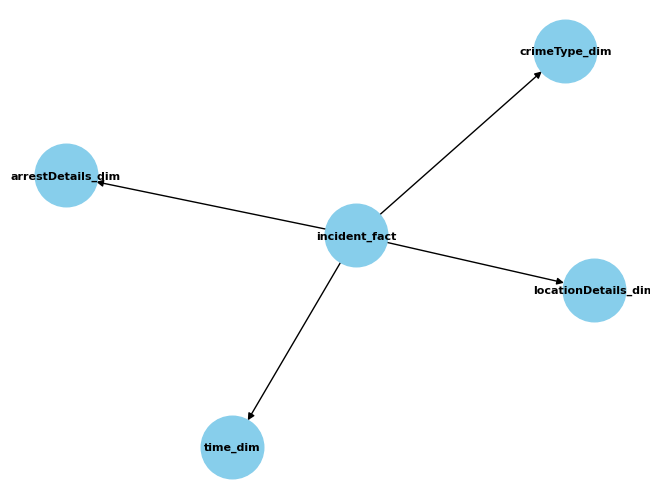

In [17]:
# plot the graph
pos = nx.spring_layout(G, seed=38)  
labels = nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, node_size=2030, node_color='skyblue', font_size=8, font_color='black', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()